In [ ]:
# !pip install yfinance

In [1]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import random
from absl import logging
logging.set_verbosity(logging.ERROR)
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda, Concatenate
from tensorflow.keras.optimizers import Adam
from collections import deque
import random
import gym
from gym import spaces
import datetime
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

2025-05-22 09:52:07.968128: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747907528.243016      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747907528.330468      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:596: UserWarning: WARN: plugin: shimmy.registration:register_gymnasium_envs raised Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py", line 594, in load_plugin_envs
    fn()
  File "/usr/local/lib/python3.11/dist-packages/shimmy/registration.py", line 304, in register_gymnasium_envs
    _register_atar

In [2]:
import yfinance as yf

In [ ]:
# # Downloading the data
# ticker='BTC-USD' # We are using dollar as currency
# start_date = '2020-01-01'
# end_date = '2025-01-01' 
# # We are using data from last 5 years
# df = yf.download("BTC-USD", start=start_date, end=end_date, interval='1d')

# # Standard OHLCV (Open-High-Low-Close-Volume) format
# df.rename(columns={'Open':'Open', 'High':'High', 'Low':'Low', 'Close':'Close', 'Volume':'Volume'}, inplace=True)
 
# This just doesnt work some times and it also returns multi-indexed columns
# Dont ever trust yfinance

In [3]:
df=pd.read_csv("/kaggle/input/bitcoin-20-25/bitcoin_2020_2025")

In [4]:
df

,Date,Close,High,Low,Open,Volume
0,2020-01-01,7200.174316,7254.330566,7174.944336,7194.892090,18565664997
1,2020-01-02,6985.470215,7212.155273,6935.270020,7202.551270,20802083465
2,2020-01-03,7344.884277,7413.715332,6914.996094,6984.428711,28111481032
3,2020-01-04,7410.656738,7427.385742,7309.514160,7345.375488,18444271275
4,2020-01-05,7411.317383,7544.497070,7400.535645,7410.451660,19725074095
...,...,...,...,...,...,...
1822,2024-12-27,94164.859375,97294.843750,93310.742188,95704.976562,52419934565
1823,2024-12-28,95163.929688,95525.898438,94014.289062,94160.187500,24107436185
1824,2024-12-29,93530.226562,95174.875000,92881.789062,95174.054688,29635885267
1825,2024-12-30,92643.210938,94903.320312,91317.132812,93527.195312,56188003691


In [5]:
def preprocess_data(df):
    """
    Args:
        df: DataFrame with OHLCV data

    Returns:
        DataFrame with preprocessed data including technical indicators
    """
    if df.isnull().sum().sum() > 0:
        print(f"Warning: Initial missing values found: {df.isnull().sum().sum()}")
        df = df.ffill() 
        df = df.bfill()
    else:
        print("No missing values found, skipping fill operations.")
    df['SMA7'] = df['Close'].rolling(window=7).mean()  # 7-day SMA
    df['SMA25'] = df['Close'].rolling(window=25).mean() # 25-day SMA
    df['EMA12'] = df['Close'].ewm(span=12).mean() # 12-day EMA
    df['EMA26'] = df['Close'].ewm(span=26).mean() # 26-day EMA
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['Signal'] = df['MACD'].ewm(span=9).mean()   # 9-day EMA of MACD
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=14).mean() # 14-day gain
    loss = -delta.where(delta < 0, 0).rolling(window=14).mean() # 14-day loss
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df['Daily_Return'] = df['Close'].pct_change()
    df['Norm_Close'] = df['Close'] / df['Close'].iloc[0]
    df.dropna(inplace=True)

    return df

# Preprocessing the data
df_processed = preprocess_data(df.copy())



No missing values found, skipping fill operations.


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


In [6]:
df_processed.tail()

,Date,Close,High,Low,Open,Volume,SMA7,SMA25,EMA12,EMA26,MACD,Signal,RSI,Daily_Return,Norm_Close
1822,2024-12-27,94164.859375,97294.843750,93310.742188,95704.976562,52419934565,96421.652902,99092.389688,97572.353116,97319.807469,252.545647,1324.268908,36.281259,-0.017022,13.078136
1823,2024-12-28,95163.929688,95525.898438,94014.289062,94160.187500,24107436185,96127.253348,99058.860312,97201.826435,97160.112818,41.713616,1067.757850,38.710142,0.010610,13.216892
1824,2024-12-29,93530.226562,95174.875000,92881.789062,95174.054688,29635885267,95902.294643,98849.328125,96636.964916,96891.232355,-254.267439,803.352792,29.454413,-0.017167,12.989995
1825,2024-12-30,92643.210938,94903.320312,91317.132812,93527.195312,56188003691,95610.433036,98691.313750,96022.541227,96576.564102,-554.022875,531.877659,23.609409,-0.009484,12.866801
1826,2024-12-31,93429.203125,96090.601562,91914.031250,92643.250000,43625106843,94860.877232,98431.653438,95623.566134,96343.426252,-719.860117,281.530104,25.590100,0.008484,12.975964


In [7]:
df_processed.columns

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'SMA7', 'SMA25',
       'EMA12', 'EMA26', 'MACD', 'Signal', 'RSI', 'Daily_Return',
       'Norm_Close'],
      dtype='object')

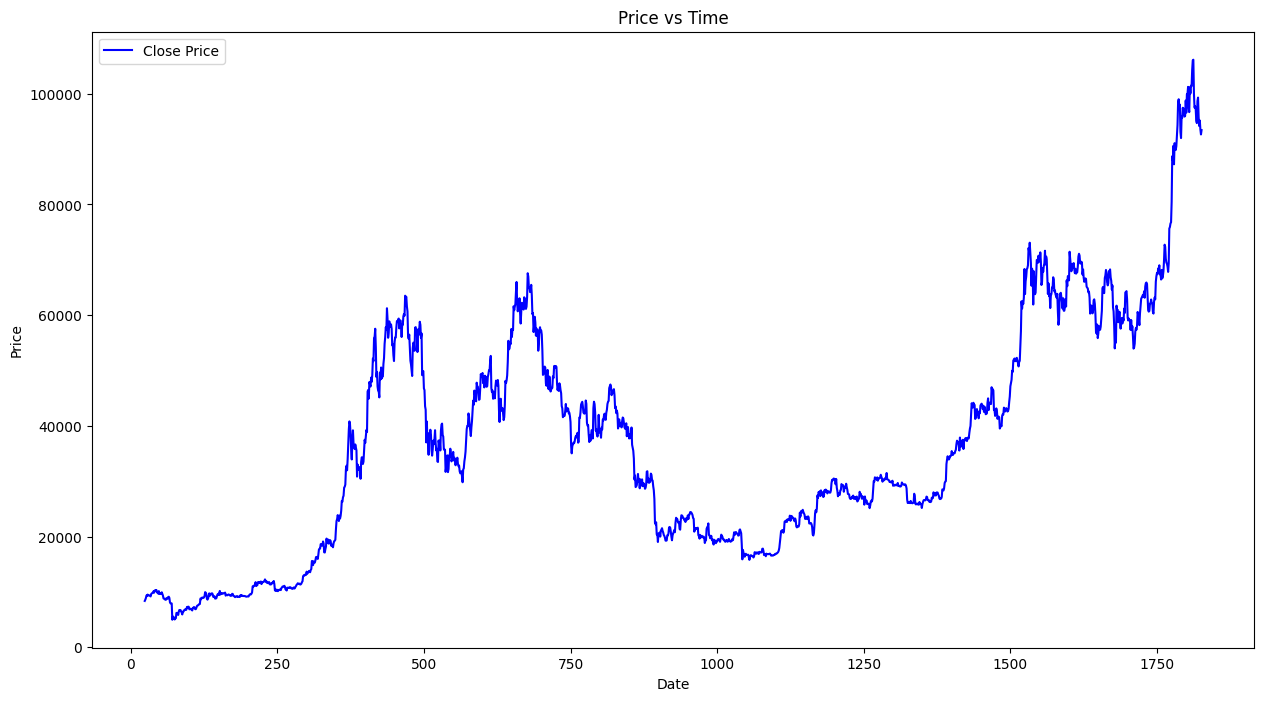

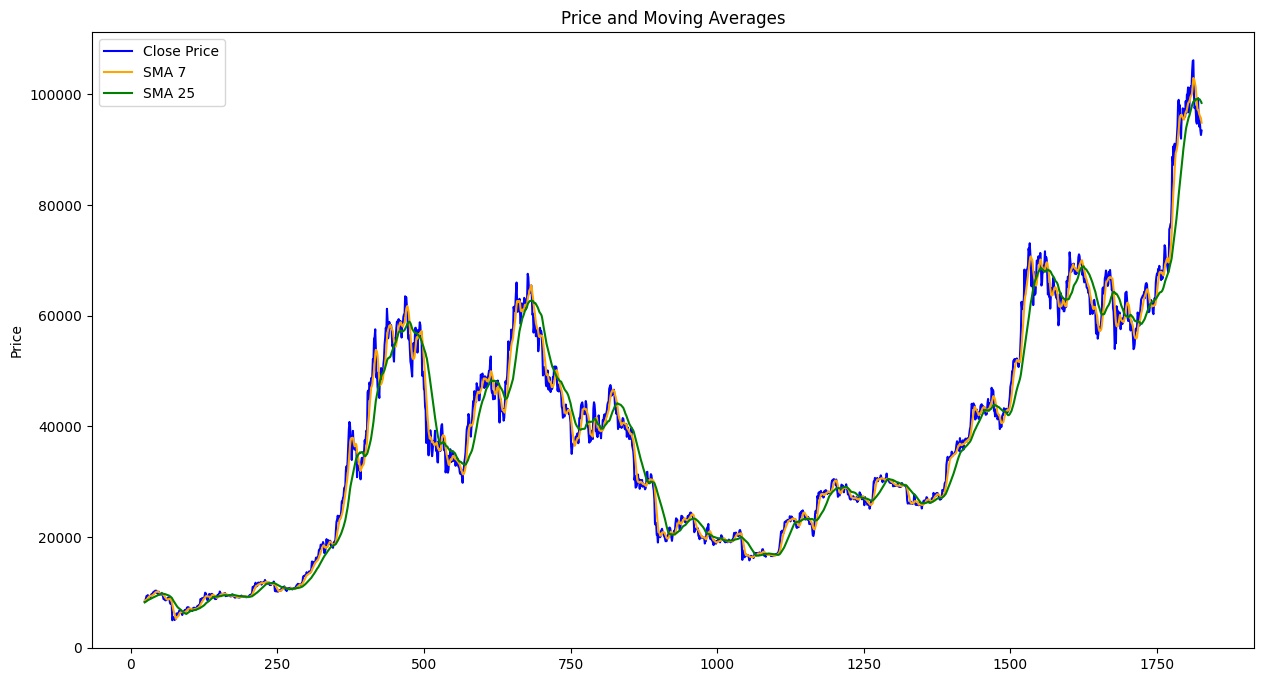

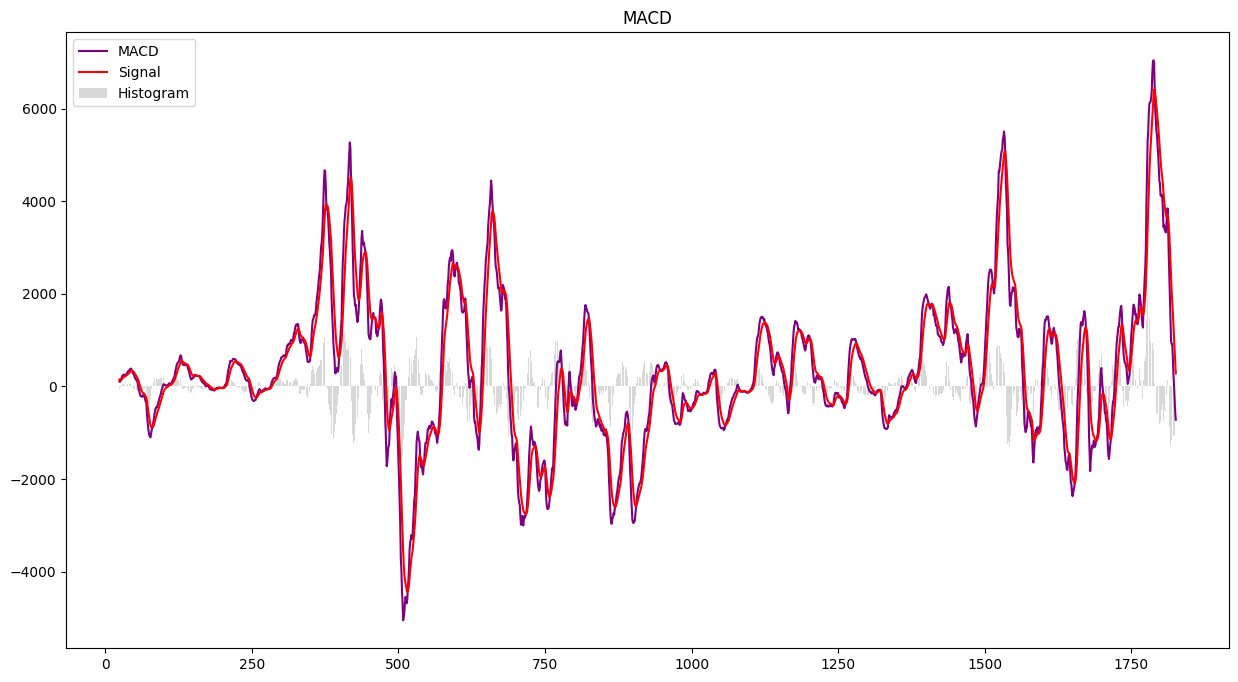

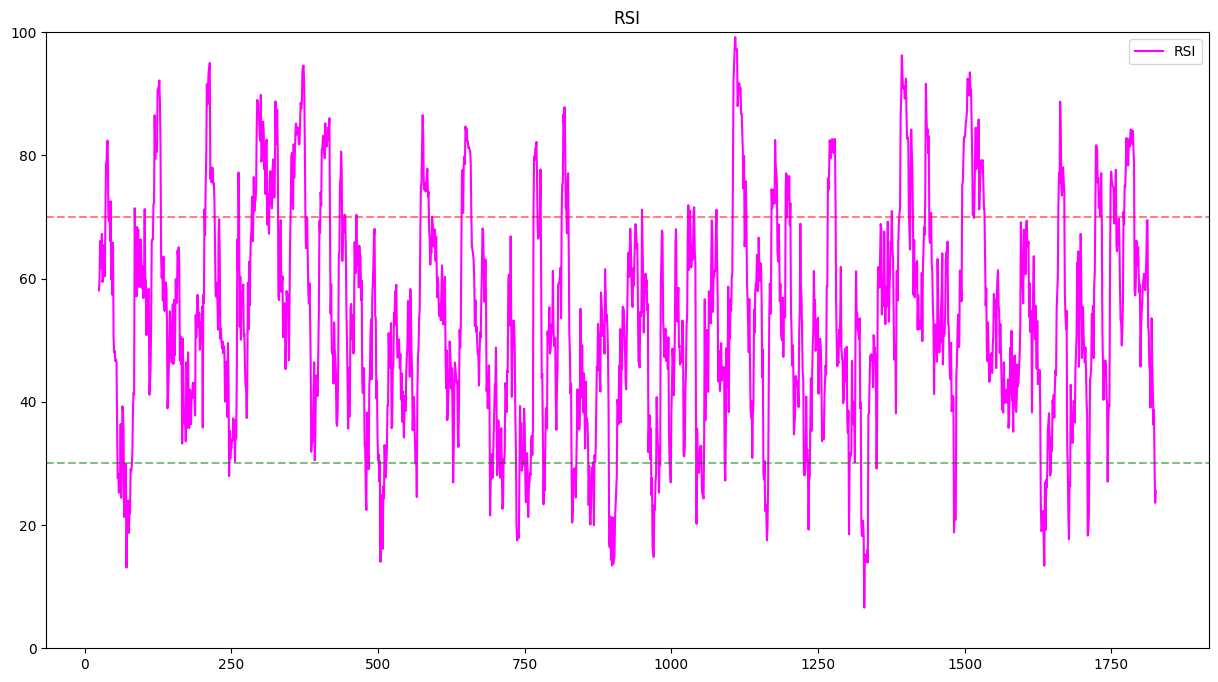

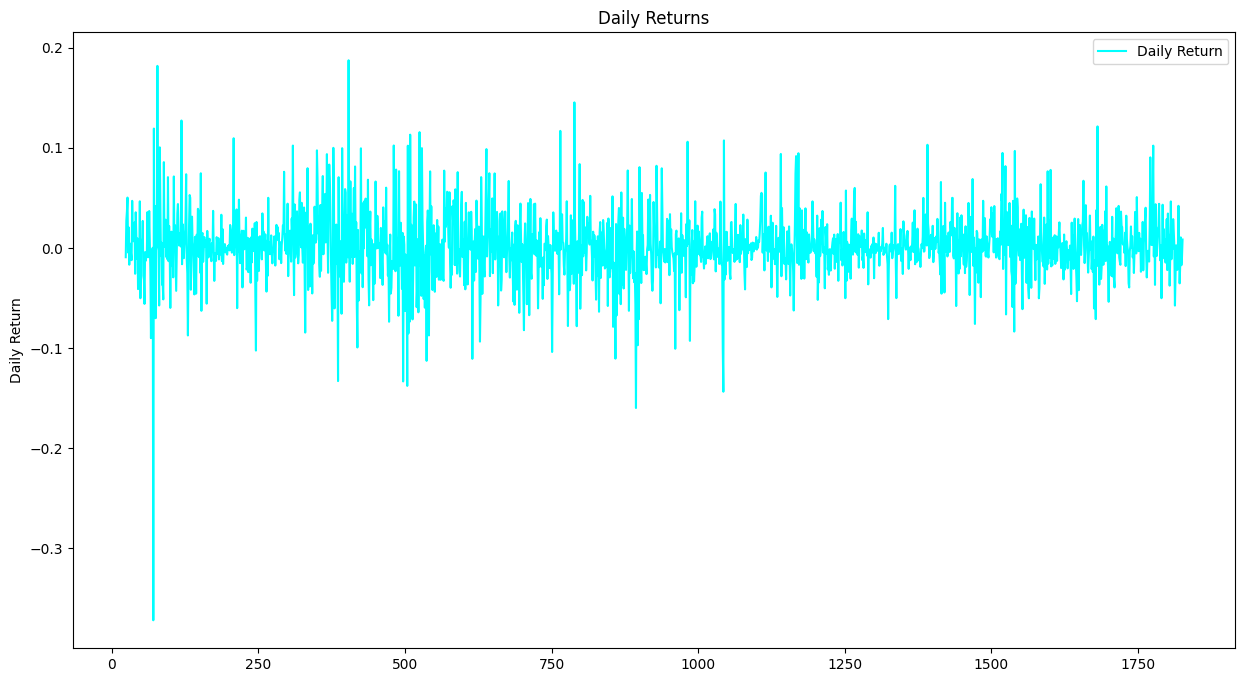

In [8]:
import matplotlib.pyplot as plt

def visualize_data(df):
    """
    Visualize the cryptocurrency data with indicators, one graph at a time
    
    Args:
        df: DataFrame with preprocessed data
    """

    plot_df = df
    
    # 1. Plot Price vs. Time (Close Price over Time)
    plt.figure(figsize=(15, 8))  
    plt.plot(plot_df.index, plot_df['Close'], label='Close Price', color='blue')
    plt.title('Price vs Time')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()  # Display the plot
    
    # 2. Price and Moving Averages
    plt.figure(figsize=(15, 8)) 
    plt.plot(plot_df.index, plot_df['Close'], label='Close Price', color='blue')
    plt.plot(plot_df.index, plot_df['SMA7'], label='SMA 7', color='orange')
    plt.plot(plot_df.index, plot_df['SMA25'], label='SMA 25', color='green')
    plt.title('Price and Moving Averages')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
    
    # 3. MACD
    plt.figure(figsize=(15, 8))  
    plt.plot(plot_df.index, plot_df['MACD'], label='MACD', color='purple')
    plt.plot(plot_df.index, plot_df['Signal'], label='Signal', color='red')
    plt.bar(plot_df.index, plot_df['MACD'] - plot_df['Signal'], alpha=0.3, label='Histogram', color='gray')
    plt.title('MACD')
    plt.legend()
    plt.show()
    
    # 4. RSI
    plt.figure(figsize=(15, 8))
    plt.plot(plot_df.index, plot_df['RSI'], label='RSI', color='magenta')
    plt.axhline(y=70, color='r', linestyle='--', alpha=0.5)
    plt.axhline(y=30, color='g', linestyle='--', alpha=0.5)
    plt.title('RSI')
    plt.ylim(0, 100)
    plt.legend()
    plt.show()  
    
    # 5. Daily Returns
    plt.figure(figsize=(15, 8))
    plt.plot(plot_df.index, plot_df['Daily_Return'], label='Daily Return', color='cyan')
    plt.title('Daily Returns')
    plt.ylabel('Daily Return')
    plt.legend()
    plt.show()

# Visualising the data
visualize_data(df_processed)


In [12]:
class TradingEnvironment:
    def __init__(self, data, history_t=90, transaction_cost=0.001):
        self.data = data
        self.history_t = history_t
        self.transaction_cost = transaction_cost
        self.reset()
        
    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 0
        self.positions = []
        self.position_value = 0
        self.history_price = [0 for _ in range(self.history_t)]
        self.history_returns = [0 for _ in range(self.history_t)]
        return self._get_observation()
    
    def _get_observation(self):
        current_row = self.data.iloc[self.t, :]
        obs = [self.position_value, len(self.positions)]
        obs.extend(self.history_price)
        obs.extend(self.history_returns)
        obs.extend([
            current_row['Norm_Close'],  # Normalized close price
            current_row['SMA7'],        # 7-day Simple Moving Average
            current_row['SMA25'],       # 25-day Simple Moving Average
            current_row['EMA12'],       # 12-day Exponential Moving Average
            current_row['EMA26'],       # 26-day Exponential Moving Average
            current_row['MACD'],        # Moving Average Convergence Divergence
            current_row['Signal'],      # Signal line
            current_row['RSI'],         # Relative Strength Index
            current_row['Daily_Return'] # Daily return
        ])
        return obs
    
    def step(self, act):
        current_price = self.data.iloc[self.t, :]['Close']
        reward = 0
        info = {}

        if act == 1:  # Buy
            self.positions.append(current_price)
            cost = current_price * self.transaction_cost
            reward -= cost
            info.update(action='buy', price=current_price, cost=cost)

        elif act == 2:  # Sell
            if not self.positions:
                reward = -1
                info['action'] = 'sell_error'
            else:
                profits = 0
                for p in self.positions:
                    transaction_profit = (current_price - p) - (current_price * self.transaction_cost)
                    profits += transaction_profit
                reward = profits
                self.profits += profits
                self.positions.clear()
                info.update(action='sell', price=current_price, profit=profits)

        else:
            info['action'] = 'hold'

        # Increasing the time
        self.t += 1
        if self.t >= len(self.data) - 1:
            self.done = True

        # Update history if not done
        if not self.done:
            next_price = self.data.iloc[self.t, :]['Close']
            # update position value
            self.position_value = sum((next_price - p) for p in self.positions)
            # update histories
            self.history_price.pop(0)
            self.history_price.append(next_price)
            self.history_returns.pop(0)
            self.history_returns.append(self.data.iloc[self.t, :]['Daily_Return'])

        # Scaling rewards
        if not self.done:
            if reward > 0:
                reward = min(1.0, reward / current_price * 10)
            elif reward < 0:
                reward = max(-1.0, reward / current_price * 10)
        else:
            # Episode end liquidation uses current_price
            if self.positions:
                final_value = sum(
                    (current_price - p) - (current_price * self.transaction_cost)
                    for p in self.positions
                )
                reward += final_value
                info['final_liquidation'] = final_value
                self.positions.clear()
            info['total_profit'] = self.profits

        return self._get_observation(), reward, self.done, info

In [36]:
import copy
import time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

class DDDQNTrainer:
    class QNetwork(nn.Module):
        def __init__(self, input_dim, hidden_dim, output_dim):
            super().__init__()
            self.fc1 = nn.Linear(input_dim, hidden_dim)
            self.fc2 = nn.Linear(hidden_dim, hidden_dim)
            self.fc3 = nn.Linear(hidden_dim, hidden_dim // 2)
            self.fc4 = nn.Linear(hidden_dim, hidden_dim // 2)
            self.state_value = nn.Linear(hidden_dim // 2, 1)
            self.advantage = nn.Linear(hidden_dim // 2, output_dim)

        def forward(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            hs = F.relu(self.fc3(h))
            ha = F.relu(self.fc4(h))
            state_val = self.state_value(hs)
            adv = self.advantage(ha)
            adv_mean = adv.mean(dim=1, keepdim=True)
            return state_val + (adv - adv_mean)

    def __init__(self, env, hidden_size=100, gamma=0.97,
                 memory_size=200, batch_size=50,
                 train_freq=10, update_q_freq=20,
                 epsilon_start=1.0, epsilon_min=0.1,
                 epsilon_decay=1e-3, start_reduce_epsilon=200,
                 epoch_num=100):
        self.env = env
        self.hidden_size = hidden_size
        self.gamma = gamma
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.train_freq = train_freq
        self.update_q_freq = update_q_freq
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.start_reduce_epsilon = start_reduce_epsilon
        self.epoch_num = epoch_num
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        sample_obs = self.env.reset()
        self.input_dim = len(sample_obs)
        self.action_dim = 3

        self.Q = self.QNetwork(self.input_dim, hidden_size, self.action_dim).to(self.device)
        self.Q_target = copy.deepcopy(self.Q).to(self.device)
        self.optimizer = optim.Adam(self.Q.parameters())
        self.memory = []
        self.total_step = 0

        self.total_rewards = []
        self.total_losses = []
        self.total_profits = []

    def train(self):
        step_max = len(self.env.data) - 1
        start_time = time.time()

        for epoch in range(self.epoch_num):
            obs = self.env.reset()
            total_reward = 0
            total_loss = 0
            done = False
            step = 0

            while not done and step < step_max:
                if np.random.rand() < self.epsilon:
                    action = np.random.randint(self.action_dim)
                else:
                    state_tensor = torch.tensor(obs, dtype=torch.float32, device=self.device).unsqueeze(0)
                    with torch.no_grad():
                        q_out = self.Q(state_tensor)
                    action = q_out.argmax(dim=1).item()

                step_result = self.env.step(action)
                if len(step_result) == 4:
                    next_obs, reward, done, info = step_result
                else:
                    next_obs, reward, done = step_result
                    info = {}

                self.memory.append((obs, action, reward, next_obs, done))
                if len(self.memory) > self.memory_size:
                    self.memory.pop(0)

                if len(self.memory) == self.memory_size and self.total_step % self.train_freq == 0:
                    batch = random.sample(self.memory, self.batch_size)
                    bs, ba, br, bnext, bd = zip(*batch)

                    bs = torch.tensor(bs, dtype=torch.float32, device=self.device)
                    ba = torch.tensor(ba, dtype=torch.long, device=self.device)
                    br = torch.tensor(br, dtype=torch.float32, device=self.device)
                    bnext = torch.tensor(bnext, dtype=torch.float32, device=self.device)
                    bd = torch.tensor(bd, dtype=torch.float32, device=self.device)

                    q_values = self.Q(bs)
                    q_val = q_values.gather(1, ba.unsqueeze(1)).squeeze(1)

                    with torch.no_grad():
                        next_q = self.Q(bnext)
                        next_actions = next_q.argmax(dim=1, keepdim=True)
                        q_target_next = self.Q_target(bnext)
                        q_target_val = q_target_next.gather(1, next_actions).squeeze(1)
                        target = br + self.gamma * q_target_val * (1 - bd)

                    loss = F.mse_loss(q_val, target)
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
                    total_loss += loss.item()

                if self.total_step % self.update_q_freq == 0:
                    self.Q_target.load_state_dict(self.Q.state_dict())

                if self.total_step > self.start_reduce_epsilon:
                    self.epsilon = max(self.epsilon_min, self.epsilon - self.epsilon_decay)

                obs = next_obs
                total_reward += reward
                step += 1
                self.total_step += 1

            self.total_rewards.append(total_reward)
            self.total_losses.append(total_loss)
            self.total_profits.append(getattr(self.env, 'profits', 0))

            print(f"Epoch {epoch+1:3d} | Epsilon {self.epsilon:.3f} | Steps {self.total_step:5d} | "
                  f"Return {total_reward:.4f} | Loss {total_loss:.4f} | Profit {self.total_profits[-1]:.4f}")

            if (epoch + 1) % 5 == 0:
                avg_r = np.mean(self.total_rewards[-5:])
                avg_l = np.mean(self.total_losses[-5:])
                elapsed = time.time() - start_time
                print(f"---- Last 5 episodes Avg Return {avg_r:.4f} | Avg Loss {avg_l:.4f} | Time {elapsed:.1f}s ----")
                start_time = time.time()

        return self.Q

    def test(self, test_env, render=False):
        obs = test_env.reset()
        done = False
        total_reward = 0
        total_profit = 0
        actions = []

        while not done:
            state_tensor = torch.tensor(obs, dtype=torch.float32, device=self.device).unsqueeze(0)
            with torch.no_grad():
                q_out = self.Q(state_tensor)
            action = q_out.argmax(dim=1).item()
            actions.append(action)
            result = test_env.step(action)
            if len(result) == 4:
                next_obs, reward, done, info = result
            else:
                next_obs, reward, done = result
            total_reward += reward
            obs = next_obs
            if render and hasattr(test_env, "render"):
                test_env.render()

        total_profit = getattr(test_env, 'profits', 0)

        print(f"Test completed | Total Reward: {total_reward:.4f} | Total Profit: {total_profit:.4f}")
        return total_reward, total_profit, actions


    def plot_metrics(self):
        plt.figure(figsize=(14, 4))

        plt.subplot(1, 3, 1)
        plt.plot(self.total_rewards, label='Reward')
        plt.title('Episode Return')
        plt.xlabel('Episode')
        plt.ylabel('Return')
        plt.grid()

        plt.subplot(1, 3, 2)
        plt.plot(self.total_losses, label='Loss', color='orange')
        plt.title('Episode Loss')
        plt.xlabel('Episode')
        plt.ylabel('Loss')
        plt.grid()

        plt.subplot(1, 3, 3)
        plt.plot(self.total_profits, label='Profit', color='green')
        plt.title('Episode Profit')
        plt.xlabel('Episode')
        plt.ylabel('Profit')
        plt.grid()

        plt.tight_layout()
        plt.show()


In [37]:

train_size = int(len(df_processed) * 0.7) 
train_data = df_processed[:train_size] 
test_data = df_processed[train_size:]

print(f"Training data range: {train_data.index.min()} to {train_data.index.max()}")
print(f"Testing data range: {test_data.index.min()} to {test_data.index.max()}")





Training data range: 24 to 1285
Testing data range: 1286 to 1826


In [38]:
env = TradingEnvironment(train_data)
print(env.reset())
for _ in range(3):
    pact = np.random.randint(3)
    print(env.step(pact))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.1621729264502805, 8572.922293526786, 8201.0397265625, 8518.512511546209, 8412.658441801805, 105.85406974440411, 150.4847532559383, 58.09928740398727, -0.00918684685986848]
([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8596

Epoch   1 | Epsilon 0.100 | Steps  1261 | Return 0.9363 | Loss 2687958.6597 | Profit -64627.4346
Epoch   2 | Epsilon 0.100 | Steps  2522 | Return 10356.6503 | Loss 344543.5544 | Profit 302434.0627
Epoch   3 | Epsilon 0.100 | Steps  3783 | Return -11.4710 | Loss 13733763.3201 | Profit -57129.0984
Epoch   4 | Epsilon 0.100 | Steps  5044 | Return -2318.0628 | Loss 169389.2977 | Profit 79379.5790
Epoch   5 | Epsilon 0.100 | Steps  6305 | Return -2.9926 | Loss 909710.6754 | Profit -2516.3334
---- Last 5 episodes Avg Return 1605.0120 | Avg Loss 3569073.1015 | Time 8.7s ----
Epoch   6 | Epsilon 0.100 | Steps  7566 | Return -521.8727 | Loss 21521.1738 | Profit -224935.1565
Epoch   7 | Epsilon 0.100 | Steps  8827 | Return -254.7280 | Loss 63636.5419 | Profit 867112.8038
Epoch   8 | Epsilon 0.100 | Steps 10088 | Return -67.4642 | Loss 52032.5182 | Profit 713325.0290
Epoch   9 | Epsilon 0.100 | Steps 11349 | Return 3.9896 | Loss 8445.3420 | Profit -21354.1125
Epoch  10 | Epsilon 0.100 | Steps 126

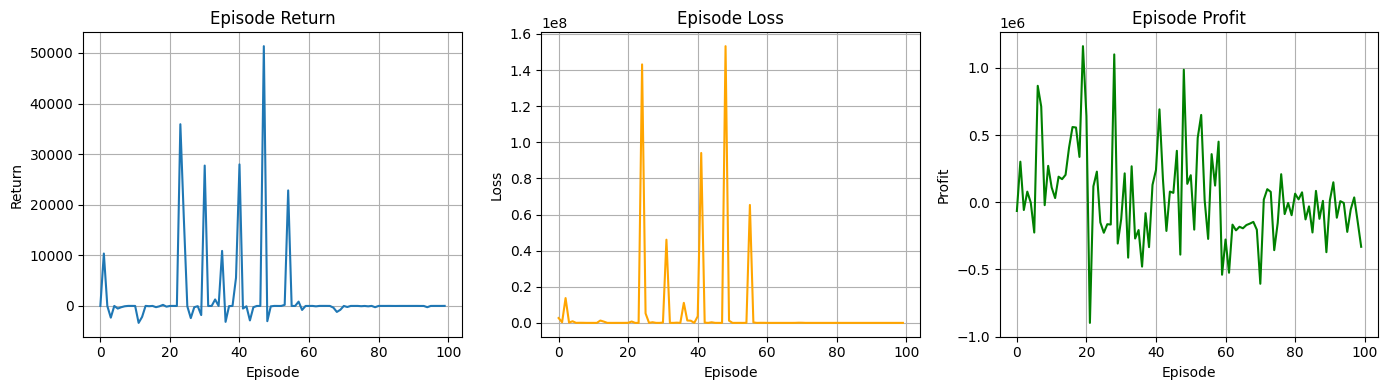

In [39]:

trainer = DDDQNTrainer(env)
trained_model = trainer.train()
trainer.plot_metrics()

In [40]:
test_env=TradingEnvironment(test_data)
test_reward, test_profit, test_actions = trainer.test(test_env)

Test completed | Total Reward: 0.8411 | Total Profit: 31233.0223


In [41]:
# Our model gained a profit of 31233 dollars based on initial balance of 10000